# Sentiment Analysis for Mental Health
This workbook contains all of the code used for the *sentiment analysis for mental health* project for the module *ECMM447 - Social Networks & Text Analysis* by candidate no. *021739*.

## 0. Reading and Exploring the Data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
data = pd.read_csv("Combined Data.csv")

# Undersampling for quicker training (and in order to use TF-IDF)
data = data.groupby('status').apply(lambda x: x.sample(n=758)) # class size of 758 equates to 10% of entire dataset
data.reset_index(drop=True, inplace=True)
data.head()

,Unnamed: 0,statement,status
0,497,How do you not think about negative things and...,Anxiety
1,318,The combination of anxiety and anxiety gives m...,Anxiety
2,34574,Got a minor sunburn today So I've spent the pa...,Anxiety
3,52079,weed anxiety i recently woke up from a really ...,Anxiety
4,35518,Can a girl get pregnant from a towel? so after...,Anxiety


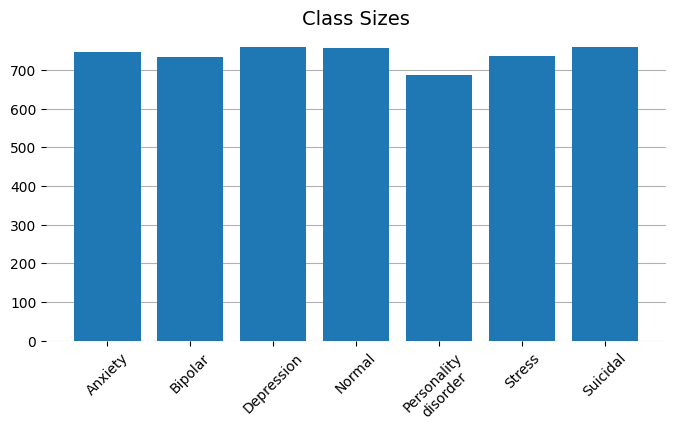

status
Anxiety                  746
Bipolar                  733
Depression               758
Normal                   757
Personality\ndisorder    687
Stress                   737
Suicidal                 758
Name: statement, dtype: int64


In [ ]:
# Analysing the class sizes
# (For the report, this was ran with the last three lines from the previous cell commented out)
class_sizes = data.replace('Personality disorder', 'Personality\ndisorder').groupby('status').count()['statement']

fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(class_sizes.index, class_sizes.values, zorder=2)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', zorder=1)
ax.set_frame_on(False)
ax.set_title('Class Sizes', fontsize=14)
plt.show()
print(class_sizes)

In [3]:
# Assigning numerical labels for each class
def assign_label(status):
    statuses = ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']
    return statuses.index(status)

# Filling nulls and replacing strange apostraphe-like characters with apostraphes
data.fillna('', inplace=True)
data['statement'] = data['statement'].str.replace('’', "'").str.replace('´', "'")
data['label'] = data['status'].apply(assign_label)

## 1. Pre-processing

In [4]:
# Cleaning, removing stop words, making lowercase, lemmatising
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatiser = WordNetLemmatizer()

stop_words.add('im') # There seems to be a few cases where people missed the apostraphe in "I'm"

def process_text(statement):
    """
    This function removes punctuation, makes lowercase, and applies lemmatisation to a provided statement.
    """
    statement = re.sub(r'[.,!?"]', '', statement) # Don't want to remove appostraphes just yet in case they're in stop words

    words = [lemmatiser.lemmatize(word.lower())
              for word in statement.split(' ') if word.lower() not in stop_words]

    return ' '.join([re.sub(r'[^a-z0-9]', '', word) for word in words])

data['statement_clean'] = data['statement'].apply(process_text)
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azaza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\azaza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Unnamed: 0,statement,status,label,statement_clean
0,497,How do you not think about negative things and...,Anxiety,0,think negative thing get anxious easily want l...
1,318,The combination of anxiety and anxiety gives m...,Anxiety,0,combination anxiety anxiety give terrible head...
2,34574,Got a minor sunburn today So I've spent the pa...,Anxiety,0,got minor sunburn today spent past 5 hour frea...
3,52079,weed anxiety i recently woke up from a really ...,Anxiety,0,weed anxiety recently woke really bad high abs...
4,35518,Can a girl get pregnant from a towel? so after...,Anxiety,0,girl get pregnant towel masturbated cleaned to...


## 2. Feature Extraction

### 2.1 Bag-of-words (TFIDF)
This feature set is created using the Scikit-learn ```TfidfVectorizer()``` object.

In [7]:
tfidf_vectoriser = TfidfVectorizer()
X_bow = tfidf_vectoriser.fit_transform(data['statement_clean']).toarray()

In [8]:
print(X_bow.shape)

(5306, 21798)


In [9]:
# Getting the top 5 words based on TF-IDF score for each class
def get_word(id):
    return next((k for k, v in tfidf_vectoriser.vocabulary_.items() if v == id), "Key not found")

top_5_words = {}

for class_name in ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']:
    subset = X_bow[data['status'] == class_name]
    counts = subset.sum(axis=0)
    top_5_ids = np.argsort(-counts)[:5]
    top_5_words[class_name] = [get_word(id) for id in top_5_ids]

print(top_5_words)

{'Anxiety': ['anxiety', 'restless', 'feel', 'like', 'heart'], 'Bipolar': ['bipolar', 'feel', 'like', 'know', 'get'], 'Depression': ['feel', 'like', 'depression', 'want', 'life'], 'Normal': ['go', 'want', 'morning', 'oh', 'really'], 'Personality disorder': ['like', 'people', 'avpd', 'feel', 'even'], 'Stress': ['stress', 'like', 'feel', 'get', 'know'], 'Suicidal': ['want', 'cannot', 'life', 'feel', 'like']}


In [10]:
# Applying PCA to reduce dimensionality of the bag-of-words vector
pca = PCA(n_components=1000)
pca.fit(X_bow)
X_bow = pca.transform(X_bow)

### 2.2 NRC Emotion Lexicon
This feature set is created by utilising the lexicon dataset found at https://www.saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm.

In [ ]:
# Loading the NRC emotion lexicon dataset
lexicon = pd.read_csv('NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', delimiter='\t', header=None)
lexicon.columns = ['word', 'emotion', 'flag']
lexicon = lexicon[lexicon['flag'] == 1]
emotions = lexicon['emotion'].unique().tolist()
emotions.sort()
lexicon['emotion_code'] = lexicon['emotion'].apply(lambda x: emotions.index(x)) # Assigning codes to each emotion

lexicon.drop_duplicates(subset=['emotion']).sort_values(by='emotion').head(10) # Visualising an example for each emotion

,word,emotion,flag,emotion_code
30,abandoned,anger,1,0
611,abundance,anticipation,1,1
152,aberration,disgust,1,2
23,abandon,fear,1,3
494,absolution,joy,1,4
25,abandon,negative,1,5
76,abba,positive,1,6
27,abandon,sadness,1,7
48,abandonment,surprise,1,8
19,abacus,trust,1,9


In [ ]:
# Dictionary mapping words to lists of emotion codes
word_to_emotions = lexicon.groupby('word')['emotion_code'].apply(list).to_dict()

def NRC_vector(statement):
    """
    This function creates an NRC emotion lexicon vector for some provided statement. 
    """
    vector = np.zeros(10)  # Assuming 10 emotion categories
    words = statement.split()

    for word in words:
        if word in word_to_emotions:
            for emotion_code in word_to_emotions[word]:
                vector[emotion_code] += 1

    return vector

X_nrc = np.array([NRC_vector(st) for st in data['statement_clean']])
X_nrc = X_nrc / np.tile(X_nrc.mean(axis=0), (X_nrc.shape[0], 1)) # Dividing by dataset average for each emotion

In [13]:
print(X_nrc.shape)

(5306, 10)


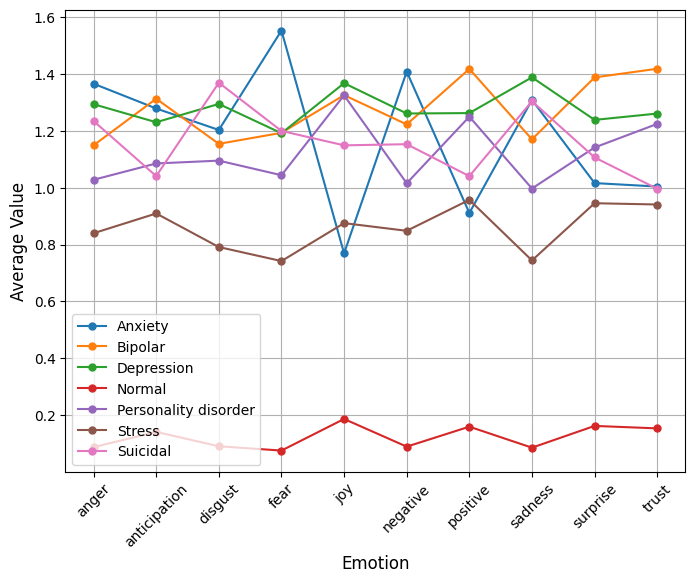

In [14]:
# Plotting averages for each class to identify patterns
fig, ax = plt.subplots(figsize=(8, 6))

for class_name in ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']:
    subset = X_nrc[data['status'] == class_name]
    avg = subset.sum(axis=0) / subset.shape[0]
    ax.plot(avg, markersize=10, marker='.', label=class_name, zorder=2)

x_tick_labels = lexicon.drop_duplicates(subset=['emotion_code']).sort_values(by='emotion_code')['emotion']

ax.set_xticks(np.arange(10), labels=x_tick_labels, rotation=45)
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Average Value', fontsize=12)
ax.grid(zorder=1)
ax.legend()
plt.show()

### 2.3 BERT Embeddings
A pre-trained BERT embedding model is used for this, https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1. The model takes roughly 1 hour and 20 minutes to process the entire dataset, and so to save time (and because embeddings should be static), a saved version of the computed feature set is loaded instead.

In [15]:
### Takes about one hour and 20 mins to run for entire dataset, so a saved copy is loaded instead ###
#import tensorflow_hub as hub
#import tensorflow_text  # Required for text processing

# Load Pretrained BERT Model
#bert_model = hub.load("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")
#preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

#texts = data['statement'].tolist()

#embeddings = []
#for i in range(0, len(texts), 1000):
#    print(f'Processed {i}')
#    batch = texts[i:i + 1000]
#    inputs = preprocessor(batch)
#    outputs = bert_model(inputs)
#    embeddings.append(outputs["pooled_output"].numpy())

#X_bert = np.vstack(embeddings)
X_bert = np.load('X_bert.npy')[data['Unnamed: 0']] # Filtering to the undersampled subset

In [16]:
print(X_bert.shape)

(5306, 512)


## 3.0 Models
This section of the code simply creates instances of each model from Scikit-learn.

In [17]:
# Loading instances for each model to be used
model_mlp = MLPClassifier()
model_svm = SVC()
model_dtr = DecisionTreeClassifier()

## 4.0 Model Selection
This section begins with a full comparison of all feature set & model combinations before fine-tuning and doing further analysis on the strongest two.

In [18]:
y = data['label'].to_numpy() # The labels to predict

In [19]:
# 10-fold cross validation to compare different feature set and model combinations
Xs = ['Bag-of-words', 'NRC emotion lexicon', 'BERT Embeddings']
models = ['MLP', 'SVM', 'Decision tree']

results_df = {'Model':[], 'Feature':[], 'Mean Accuracy':[], 'Std Accuracy':[]}

for i, X in enumerate([X_bow, X_nrc, X_bert]):
    for j, model in enumerate([model_mlp, model_svm, model_dtr]):
        print(f'{Xs[i]} & {models[j]}')
        kf = StratifiedKFold(n_splits=10, shuffle=True)
        cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
        mean_acc, std_acc = cv_scores.mean(), cv_scores.std()
        results_df['Model'].append(models[j])
        results_df['Feature'].append(Xs[i])
        results_df['Mean Accuracy'].append(mean_acc)
        results_df['Std Accuracy'].append(std_acc)

results_df = pd.DataFrame(results_df)
results_df.head(10)

Bag-of-words & MLP
Bag-of-words & SVM
Bag-of-words & Decision tree
NRC emotion lexicon & MLP
NRC emotion lexicon & SVM
NRC emotion lexicon & Decision tree
BERT Embeddings & MLP
BERT Embeddings & SVM
BERT Embeddings & Decision tree


,Model,Feature,Mean Accuracy,Std Accuracy
0,MLP,Bag-of-words,0.564831,0.026346
1,SVM,Bag-of-words,0.676777,0.015937
2,Decision tree,Bag-of-words,0.442888,0.023976
3,MLP,NRC emotion lexicon,0.355261,0.010639
4,SVM,NRC emotion lexicon,0.346591,0.017024
5,Decision tree,NRC emotion lexicon,0.316248,0.013397
6,MLP,BERT Embeddings,0.592912,0.009698
7,SVM,BERT Embeddings,0.571047,0.017423
8,Decision tree,BERT Embeddings,0.374668,0.026446


### 4.1 Fine Tuning

In [20]:
# Fine tuning the strongest model - bag-of-words + SVM
params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.01, 0.1, 1, 10, 100]}
gs = GridSearchCV(model_svm, params)
gs.fit(X_bow, y)
print(gs.best_params_)

{'C': 1, 'kernel': 'rbf'}


In [21]:
# Fine tuning the second strongest model - BERT embeddings + MLP
params = {'activation':['logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(50,), (100,), (50, 2), (100, 2)]}
gs = GridSearchCV(model_mlp, params)
gs.fit(X_bert, y)
print(gs.best_params_)

{'activation': 'logistic', 'hidden_layer_sizes': (100,)}


### 4.2 Bag-of-words SVM

The following code **reloads the dataset** as we no longer need to undersample necassarily, only for the TF-IDF vectorisation and PCA reduction.

In [5]:
# Reloading the data --
data = pd.read_csv("Combined Data.csv")

data.fillna('', inplace=True)
data['statement'] = data['statement'].str.replace('’', "'").str.replace('´', "'")
data['label'] = data['status'].apply(assign_label)
y = data['label'].to_numpy()

In [6]:
# Undersampling in order to train the TF-IDF vectoriser and PCA model ----
data_undsamp = data.groupby('status').apply(lambda x: x.sample(n=758))
data_undsamp.reset_index(drop=True, inplace=True)

tfidf_vectoriser = TfidfVectorizer()
tfidf_vectors = tfidf_vectoriser.fit_transform(data_undsamp['statement'].apply(process_text)).toarray()
pca = PCA(n_components=1000)
pca.fit(tfidf_vectors, data_undsamp['label'].to_numpy())

def bow_vec(statements):
    """
    This function uses the trained vectoriser and PCA model to process the text ready for the SVM.
    """
    global tfidf_vectoriser, pca
    statements = statements.apply(process_text)
    tfidf_vec = tfidf_vectoriser.transform(statements).toarray()
    return pca.transform(tfidf_vec)
# -------------------------------------------------------------------------

# Since TF-IDF vectors are large, the processing needs to be done in batches --
batch_size = 5000
X_bow = bow_vec(data['statement'].iloc[:batch_size])

for b in range(1, int(np.ceil(len(data)/batch_size))):
    X_bow = np.concatenate([X_bow, bow_vec(data['statement'].iloc[b*batch_size:(b+1)*batch_size])], axis=0)

In [16]:
# Bag-of-words SVM F1 analysis
X_bow_train, X_bow_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.3)

model_svm = SVC(kernel='rbf', C=1.0)

model_svm.fit(X_bow_train, y_train)
y_pred = model_svm.predict(X_bow_test)
bow_svm_results = classification_report(y_test, y_pred, output_dict=True)
print(f'Average accuracy : {bow_svm_results["accuracy"]}')
pd.DataFrame(bow_svm_results)

Average accuracy : 0.7524036950920631


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.801400,0.901042,0.672386,0.828887,1.000000,0.746305,0.689362,0.752404,0.805626,0.757319
recall,0.745321,0.615658,0.735005,0.951797,0.269022,0.377805,0.660188,0.752404,0.622114,0.752404
f1-score,0.772344,0.731501,0.702303,0.886100,0.423983,0.501656,0.674460,0.752404,0.670335,0.743678
support,1229.000000,843.000000,4585.000000,4896.000000,368.000000,802.000000,3190.000000,0.752404,15913.000000,15913.000000


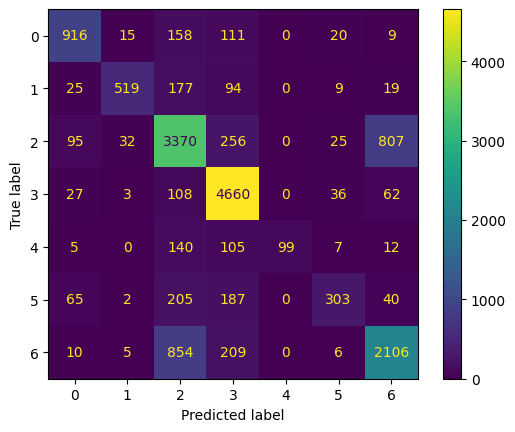

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### 4.3 BERT Embeddings MLP

In [18]:
# BERT embeddings MLP F1 analysis
X_bert = np.load('X_bert.npy')

X_bert_train, X_bert_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.3)

model_mlp = MLPClassifier(activation='logistic', hidden_layer_sizes=(100,))

model_mlp.fit(X_bert_train, y_train)
y_pred = model_mlp.predict(X_bert_test)
bert_mlp_results = classification_report(y_test, y_pred, output_dict=True)
print(f'Average accuracy : {bert_mlp_results["accuracy"]}')
pd.DataFrame(bert_mlp_results)

Average accuracy : 0.6980456230754729


,0,1,2,3,4,5,6,accuracy,macro avg,weighted avg
precision,0.654497,0.572571,0.651309,0.907156,0.483283,0.522673,0.571384,0.698046,0.623268,0.699806
recall,0.623410,0.563555,0.667669,0.888798,0.450425,0.543424,0.579401,0.698046,0.616669,0.698046
f1-score,0.638575,0.568027,0.659387,0.897883,0.466276,0.532847,0.575364,0.698046,0.619766,0.698808
support,1179.000000,889.000000,4658.000000,4892.000000,353.000000,806.000000,3136.000000,0.698046,15913.000000,15913.000000


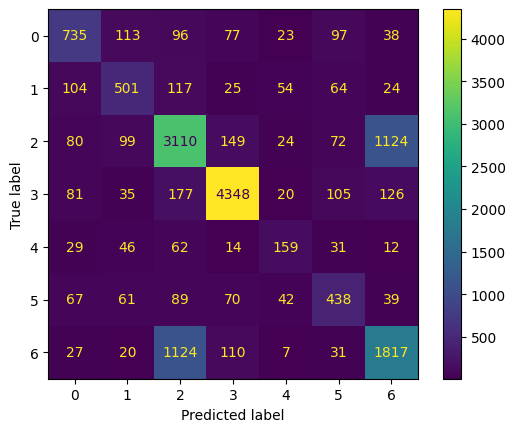

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### 4.4 Model Comparison

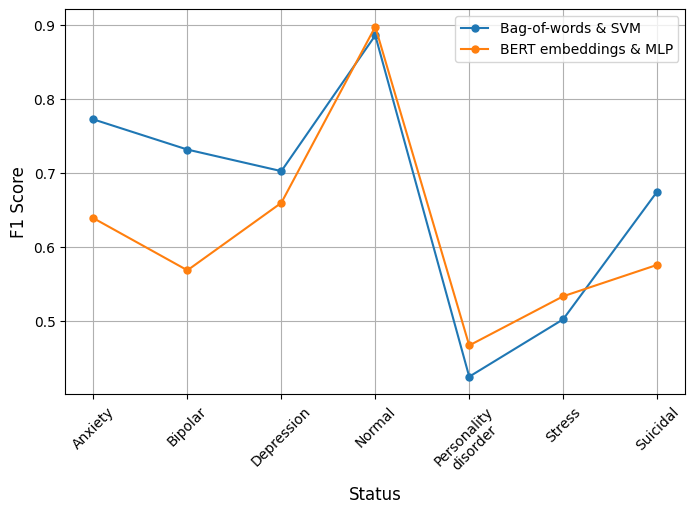

In [20]:
bow_F1 = [bow_svm_results[str(class_label)]['f1-score'] for class_label in range(7)]
bert_F1 = [bert_mlp_results[str(class_label)]['f1-score'] for class_label in range(7)]

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(bow_F1, markersize=10, marker='.', label='Bag-of-words & SVM', zorder=2)
ax.plot(bert_F1, markersize=10, marker='.', label='BERT embeddings & MLP', zorder=2)
ax.set_xticks(np.arange(7), ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality\ndisorder', 'Stress', 'Suicidal'], rotation=45)
ax.grid(zorder=1)
ax.set_xlabel('Status', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.legend()

plt.show()

In [21]:
for l, status in enumerate(['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality Dis.', 'Stress', 'Suicidal']):
    print(f"\t\t{status} & {bow_svm_results[str(l)]['precision']:.2f} & {bow_svm_results[str(l)]['recall']:.2f} & {bow_svm_results[str(l)]['f1-score']:.2f} & {bow_svm_results[str(l)]['support']:.0f} \\\\")
print('\n')
for l, status in enumerate(['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality Dis.', 'Stress', 'Suicidal']):
    print(f"\t\t{status} & {bert_mlp_results[str(l)]['precision']:.2f} & {bert_mlp_results[str(l)]['recall']:.2f} & {bert_mlp_results[str(l)]['f1-score']:.2f} & {bert_mlp_results[str(l)]['support']:.0f} \\\\")

		Anxiety & 0.80 & 0.75 & 0.77 & 1229 \\
		Bipolar & 0.90 & 0.62 & 0.73 & 843 \\
		Depression & 0.67 & 0.74 & 0.70 & 4585 \\
		Normal & 0.83 & 0.95 & 0.89 & 4896 \\
		Personality Dis. & 1.00 & 0.27 & 0.42 & 368 \\
		Stress & 0.75 & 0.38 & 0.50 & 802 \\
		Suicidal & 0.69 & 0.66 & 0.67 & 3190 \\


		Anxiety & 0.65 & 0.62 & 0.64 & 1179 \\
		Bipolar & 0.57 & 0.56 & 0.57 & 889 \\
		Depression & 0.65 & 0.67 & 0.66 & 4658 \\
		Normal & 0.91 & 0.89 & 0.90 & 4892 \\
		Personality Dis. & 0.48 & 0.45 & 0.47 & 353 \\
		Stress & 0.52 & 0.54 & 0.53 & 806 \\
		Suicidal & 0.57 & 0.58 & 0.58 & 3136 \\
